# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST. 
- Output shape (num_students, num_timesteps). The values will be in the range (0, num_asts).

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps)


There are few ways to calculate the loss and perform the training:
    1. We concatenate all trajectories (compare to comparing fragments of text to a bigger corpus) and use a sliding window, very similar to predicting the next character.
    
    2. We could train the model on each trajectory individually. We use a sliding window, e.g. of 3 ASTs.
    
Current Issues:
    1. AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [1]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize

In [6]:
# Each trajectory matrix corresponds to one hoc exercise and is
# its own data set. Mixing data sets currently does not make much
# sense since the AST IDs don't persist betweeen different hoc's.
TRAJ_MAP = {
    'hoc1': '../processed_data/traj_matrix_1.npy',
    'hoc2': '../processed_data/traj_matrix_2.npy',
    'hoc3': '../processed_data/traj_matrix_3.npy',
    'hoc4': '../processed_data/traj_matrix_4.npy',
    'hoc5': '../processed_data/traj_matrix_5.npy',
    'hoc6': '../processed_data/traj_matrix_6.npy',
    'hoc7': '../processed_data/traj_matrix_7.npy',
    'hoc8': '../processed_data/traj_matrix_8.npy',
    'hoc9': '../processed_data/traj_matrix_9.npy' 
}

TRAJ_MAP_PREFIX = '../processed_data/traj_matrix_'
TRAJ_MAP_SUFFIX = '.npy'

HOC_NUM = str(7)
DATA_SET = 'hoc' + HOC_NUM
# if DATA_SZ = -1, use entire data set
# For DATA_SZ, powers of 2 work best for performance.
DATA_SZ = -1

# DATA_SZ = -1

AST_MAP_FILE = '../processed_data/map_ast_row_' + HOC_NUM + '.pickle'

In [26]:
ast_id_to_row_map = pickle.load(open( AST_MAP_FILE, "rb" ))
# print ast_id_to_row_map[-1]

row_to_ast_id_map = {v: k for k, v in ast_id_to_row_map.items()}
# print row_to_ast_id_map[0]

In [7]:
# trajectories matrix for a single hoc exercise
# shape (num_traj, max_traj_len, num_asts)
# Note that ast_index = 0 corresponds to the <END> token,
# marking that the student has already finished.
# The <END> token does not correspond to an AST.
traj_mat = np.load(TRAJ_MAP[DATA_SET])
print traj_mat.shape
# print traj_mat[:10, :, :10]

(4195, 7, 432)


In [8]:
# if DATA_SZ specified, reduce matrix. 
# Useful to create smaller data sets for testing purposes.
if DATA_SZ != -1:
    traj_mat = traj_mat[:DATA_SZ]
print traj_mat.shape
# print traj_mat_sm[:, :, :10]

(4195, 7, 432)


In [9]:
# shuffle the first dimension of the matrix
np.random.shuffle(traj_mat)
# print traj_mat_sm[:, :, :10]

In [10]:
num_traj, max_traj_len, num_asts = traj_mat.shape
# Split data into train, val, test
# TODO: Replace with kfold validation in the future
# perhaps we can use sklearn kfold?

train_mat = traj_mat[0:7*num_traj/8,:]
val_mat =  traj_mat[7*num_traj/8: 15*num_traj/16 ,:]
test_mat = traj_mat[15*num_traj/16:num_traj,:]


In [30]:
print('Preparing network inputs and targets...')
# X_train, y_train = utils.prepare_traj_data_for_rnn(train_data)
# X_val, y_val = utils.prepare_traj_data_for_rnn(val_data)
# X_test, y_test = utils.prepare_traj_data_for_rnn(test_data)

train_data = utils.prepare_traj_data_for_rnn(train_mat)
val_data = utils.prepare_traj_data_for_rnn(val_mat)
test_data = utils.prepare_traj_data_for_rnn(test_mat)


X_train, y_train = train_data
X_val, y_val = val_data
X_test, y_test = test_data
print X_train.shape
print y_train.shape
print X_val.shape
print X_test.shape
num_train, num_timesteps, num_asts = X_train.shape

X_train_ast_ids, y_train_ast_ids = utils.convert_data_to_ast_ids(train_data, row_to_ast_id_map)
print X_train_ast_ids[:10]
print y_train_ast_ids[:10]

print num_timesteps
print ("Inputs and targets done!")

Preparing network inputs and targets...
(3670, 6, 432)
(3670, 6)
(262, 6, 432)
(263, 6, 432)
[[ 103.   42.   -1.   -1.   -1.   -1.]
 [   1.    0.   -1.   -1.   -1.   -1.]
 [   4.    1.   11.    3.    0.   -1.]
 [   8.   -1.   -1.   -1.   -1.   -1.]
 [  16.   45.   -1.   -1.   -1.   -1.]
 [   2.   10.    0.   -1.   -1.   -1.]
 [   1.    3.    4.    1.    0.   -1.]
 [   1.    3.    9.    0.   -1.   -1.]
 [   3.   33.   42.   -1.   -1.   -1.]
 [   4.   12.   -1.   -1.   -1.   -1.]]
[[ 42.  -1.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.  -1.]
 [  1.  11.   3.   0.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.]
 [ 45.  -1.  -1.  -1.  -1.  -1.]
 [ 10.   0.  -1.  -1.  -1.  -1.]
 [  3.   4.   1.   0.  -1.  -1.]
 [  3.   9.   0.  -1.  -1.  -1.]
 [ 33.  42.  -1.  -1.  -1.  -1.]
 [ 12.  -1.  -1.  -1.  -1.  -1.]]
6
Inputs and targets done!


In [31]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 1.0
reg_strength = 1e-2
grad_clip = 10
batchsize = 32
num_epochs = 2
dropout_p = 0.2
num_lstm_layers = 2
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [32]:
# create model
train_loss_acc, compute_loss_acc, probs = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [33]:
# Training!!!
train_losses, train_accuracies, val_accuracies = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize)

Starting training...
  Epoch 0 	batch 1 	loss 6.07154025508 	train acc 0.00 	val acc 64.45 
  Epoch 0 	batch 2 	loss 5.99923625596 	train acc 65.10 	val acc 65.17 
  Epoch 0 	batch 3 	loss 5.48470692779 	train acc 65.62 	val acc 65.17 
  Epoch 0 	batch 4 	loss 3.78036060032 	train acc 66.15 	val acc 65.17 
  Epoch 0 	batch 5 	loss 2.35152975175 	train acc 62.50 	val acc 65.17 
  Epoch 0 	batch 6 	loss 1.68422071387 	train acc 66.67 	val acc 65.17 
  Epoch 0 	batch 7 	loss 1.55897584048 	train acc 72.92 	val acc 65.17 
  Epoch 0 	batch 8 	loss 1.83013854068 	train acc 69.79 	val acc 65.17 
  Epoch 0 	batch 9 	loss 2.13903497033 	train acc 64.58 	val acc 65.17 
  Epoch 0 	batch 10 	loss 2.15576826638 	train acc 61.98 	val acc 65.17 
  Epoch 0 	batch 11 	loss 1.79637686514 	train acc 68.75 	val acc 65.23 
  Epoch 0 	batch 12 	loss 1.87349463054 	train acc 64.06 	val acc 65.30 
  Epoch 0 	batch 13 	loss 1.92350743189 	train acc 60.94 	val acc 65.36 
  Epoch 0 	batch 14 	loss 1.77123985656 

In [131]:
model.check_accuracy(test_data, compute_loss_acc, row_to_ast_id_map, dataset_name='test')

Testing...
Predicted AST IDs
[[   1.    7.    3.    0.   -1.   -1.]
 [ 102.    0.   -1.   -1.   -1.   -1.]
 [  11.   31.   -1.   -1.   -1.   -1.]
 [   5.    1.    0.   -1.   -1.   -1.]
 [  84.    1.    2.    0.   -1.   -1.]
 [  86.   25.   -1.   -1.   -1.   -1.]
 [   1.   24.    7.   -1.   -1.   -1.]
 [   5.    0.   -1.   -1.   -1.   -1.]
 [  10.    6.   -1.   -1.   -1.   -1.]
 [   1.    4.   25.   -1.   -1.   -1.]]
Truth AST IDs
[[   1.    7.    3.    0.   -1.   -1.]
 [ 102.    0.   -1.   -1.   -1.   -1.]
 [  11.   31.   -1.   -1.   -1.   -1.]
 [   5.    1.    0.   -1.   -1.   -1.]
 [  84.    1.    2.    0.   -1.   -1.]
 [  86.   25.   -1.   -1.   -1.   -1.]
 [   1.   24.    7.   -1.   -1.   -1.]
 [   5.    0.   -1.   -1.   -1.   -1.]
 [  10.    6.   -1.   -1.   -1.   -1.]
 [   1.    4.   25.   -1.   -1.   -1.]]
Predicted AST IDs
[[ 119.   -1.   -1.   -1.   -1.   -1.]
 [  61.   76.   25.   -1.   -1.   -1.]
 [   6.    5.   -1.   -1.   -1.   -1.]
 [  13.  113.   27.   -1.   -1.   -1.]
 

In [35]:
X_ast_ids, predicted_ast_ids, truth_ast_ids, loss, raw_acc, corrected_acc = model.check_accuracy(test_data, compute_loss_acc, row_to_ast_id_map, dataset_name='test')
print("X AST IDs")
print X_ast_ids[:10,:]
print("Predicted AST IDs")
print predicted_ast_ids[:10,:]
print ("Truth AST IDs")
print truth_ast_ids[:10, :]


Testing...
Final results:
  test loss:			1.138466
  test raw accuracy:		73.76 %
  test corrected accuracy:	49.45 %
X AST IDs
[[  10.   15.    0.   -1.   -1.   -1.]
 [ 128.    2.    0.   -1.   -1.   -1.]
 [  21.    6.    5.    0.   -1.   -1.]
 [ 114.    3.    0.   -1.   -1.   -1.]
 [  34.    7.    0.   -1.   -1.   -1.]
 [   1.   11.    4.    1.    0.   -1.]
 [   1.   10.   -1.   -1.   -1.   -1.]
 [  31.    3.   -1.   -1.   -1.   -1.]
 [   8.    3.   24.    7.    0.   -1.]
 [   3.   65.    9.   -1.   -1.   -1.]]
Predicted AST IDs
[[ 3.  3. -1. -1. -1. -1.]
 [ 0.  0. -1. -1. -1. -1.]
 [ 1.  0.  0. -1. -1. -1.]
 [-1.  0. -1. -1. -1. -1.]
 [ 0.  0. -1. -1. -1. -1.]
 [ 4.  3.  0.  0. -1. -1.]
 [ 4.  3. -1. -1. -1. -1.]
 [ 3.  0. -1. -1. -1. -1.]
 [ 3.  0.  0.  0. -1. -1.]
 [ 1.  9. -1. -1. -1. -1.]]
Truth AST IDs
[[ 15.   0.  -1.  -1.  -1.  -1.]
 [  2.   0.  -1.  -1.  -1.  -1.]
 [  6.   5.   0.  -1.  -1.  -1.]
 [  3.   0.  -1.  -1.  -1.  -1.]
 [  7.   0.  -1.  -1.  -1.  -1.]
 [ 11.   4.   1.

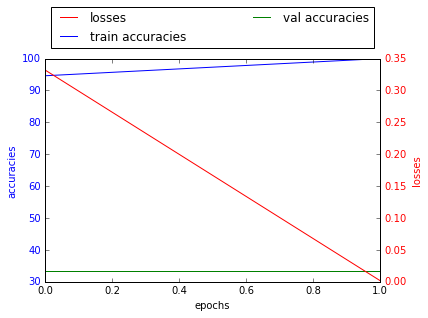

In [93]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
visualize.plot_loss_acc(DATA_SET + '_train', train_losses, train_accuracies, val_accuracies, learning_rate, reg_strength, num_epochs, num_train)

432
0
-1
